# Welcome to the notebook of Team 4 - VerSe 2019 for the ISMI Course 2019-2020. 

In this notebook a narrow pipeline is given for reproducability purposes. We will highlight the following phases of the pipeline: <b>1) Pre-processing, 2) Training </b>and <b>3) Prediction</b>. The full code can be found on the Github repository: https://github.com/mtuit/ismi-1920-VerSe-team-4. A side note is that for this project we used the <a href=https://drivendata.github.io/cookiecutter-data-science/>CookieCutter project structure</a>, however we didn't follow it to a tee, so this notebook is leading for explaining the usage of the pipeline (and not the README). 

## Main.py

Every part of the pipeline is incorperated in the main.py file and it is recommend to run this file with the desired arguments to run the desired part of the pipeline. This is also espcially helpful when one wants to perform a prediction from the command line, or in a script. In that case the ```-p``` argument combined with ```-image-dir```, and ```model``` can be used.  The full explanation of the arguments is given in the file itself or by passing the ```-h``` argument. Nevertheless we will highlight each part of the pipeline below to show how it works under the hood and how one could use our repository to program a pipeline yourself. 

## Pre-processing

First, we take a look at how we can pre-process the VerSe data. We assume the reader will have access to the normalized images, which can be found in the following directory: <b>/data/processed/normalized-images</b>. In our project we use a variety of pre-processing methods. However, before applying these methods we split the data in train, validation and test set. Then, since we are using TensorFlow Datasets, we apply the pre-processing methods when generating the input tuples. So in order the apply the pre-processing, one can create the datasets as shown below.

In [1]:
from src.data.data_loader import VerseDataset

BASE_PATH = 'data/processed/normalized-images' # base path
SEED = 2020
SPLIT = 0.8

verse_dataset = VerseDataset(base_path=BASE_PATH, seed=SEED, split=SPLIT)

### Behind the VerseDataset class

So let's delve a little bit deeper in what kind of pre-processing is actually performed. All the pre-processing functions are defined in the <b>src/data/preprocessing.py</b> file. The output of the the Tensorflow Datasets consists of 2-tuples which has the augmented input image and heatmaps of the image.

The first step in creating the input tuple is to perform histogram matching based on a reference image, which is ```verse004.mha``` in our case. This is chosen based on the fact that it looks the best visually wise. The input images are then resized to a fixed shape which corresponds to the input shape of the model and the heatmaps are computed. Both the reshaped input image and heatmaps are then augmented in similar fashion (flipped, rotated, shifted, or strechted). However each input tuple will have randomized augmentations. The code for this process can be found in ```src/data/data_loader.py``` in function ```_generate_input_tuple()```. For a manual view of pre-processing, see the code block below: 

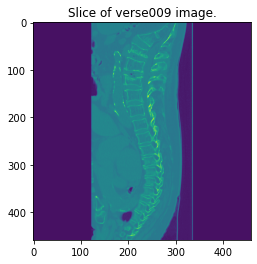

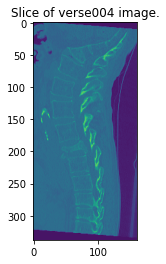

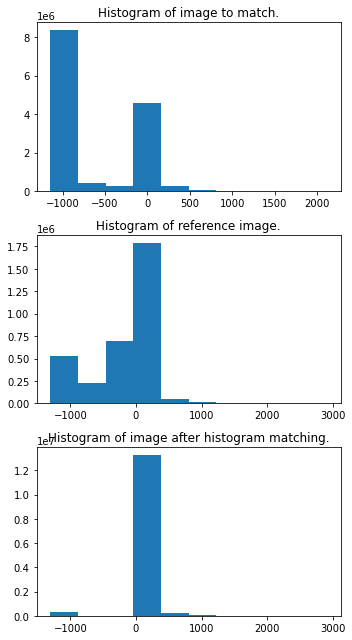

Generating heatmaps of vertebraes...
Generating heatmaps of vertebra 1
Adding empty heatmap!
Generating heatmaps of vertebra 2
Adding empty heatmap!
Generating heatmaps of vertebra 3
Adding empty heatmap!
Generating heatmaps of vertebra 4
Adding empty heatmap!
Generating heatmaps of vertebra 5
Adding empty heatmap!
Generating heatmaps of vertebra 6
Adding empty heatmap!
Generating heatmaps of vertebra 7
Adding empty heatmap!
Generating heatmaps of vertebra 8
Adding empty heatmap!
Generating heatmaps of vertebra 9


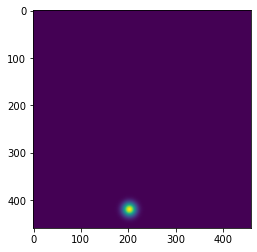

Generating heatmaps of vertebra 10


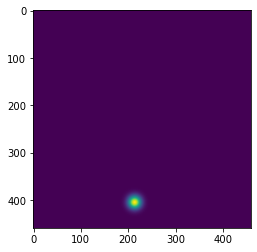

Generating heatmaps of vertebra 11


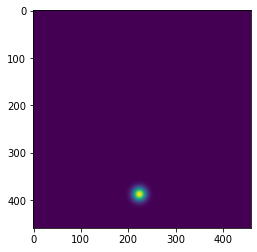

Generating heatmaps of vertebra 12


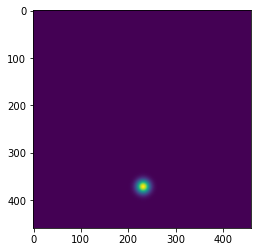

Generating heatmaps of vertebra 13


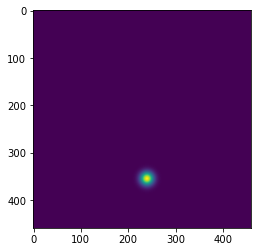

Generating heatmaps of vertebra 14


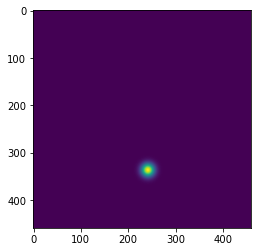

Generating heatmaps of vertebra 15


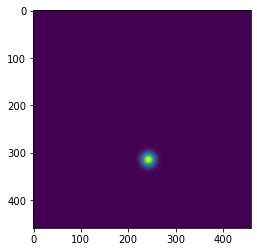

Generating heatmaps of vertebra 16


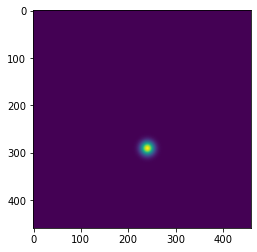

Generating heatmaps of vertebra 17


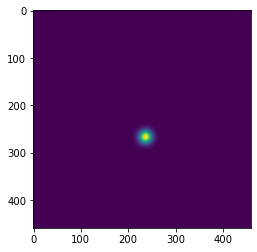

Generating heatmaps of vertebra 18


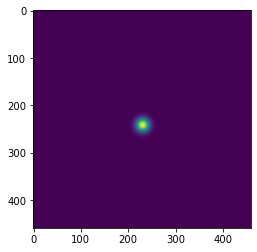

Generating heatmaps of vertebra 19


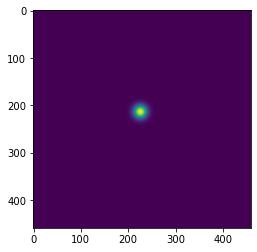

Generating heatmaps of vertebra 20


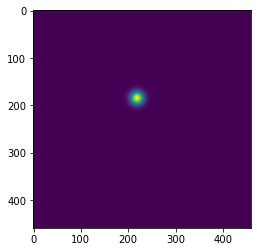

Generating heatmaps of vertebra 21


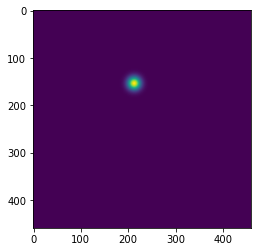

Generating heatmaps of vertebra 22


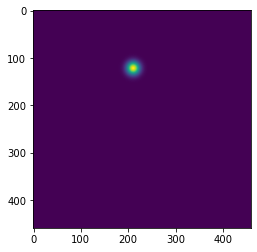

Generating heatmaps of vertebra 23


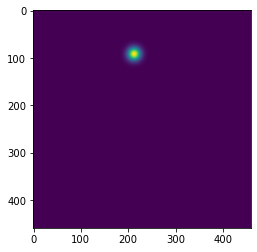

Generating heatmaps of vertebra 24


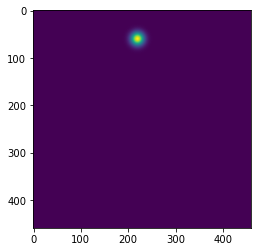

Generating heatmaps of vertebra 25
Adding empty heatmap!
Return 25 heatmaps 111.50244307518005


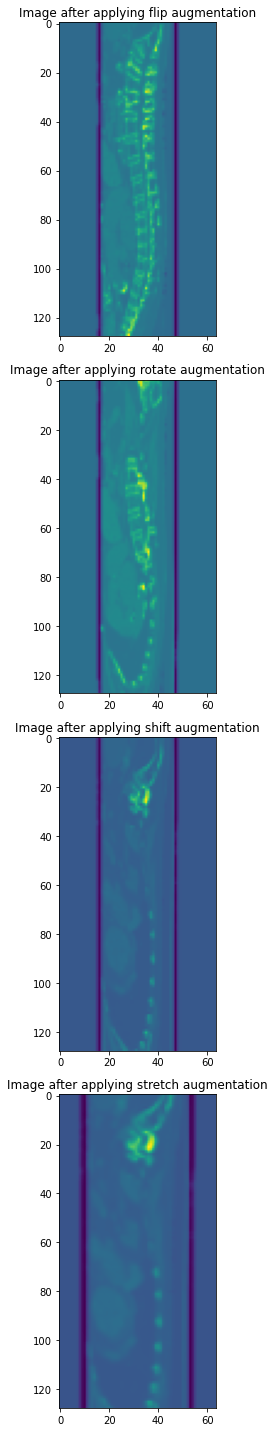

In [3]:
import os, random
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from src.data.preprocessing import generate_heatmap, augment_stretch, augment_shift, augment_rotate, augment_flip, histogram_match
from skimage import transform

SAMPLE_IMAGE      = 'verse009.mha'
REFERENCE_IMAGE   = 'verse004.mha'
INPUT_SHAPE       = (128, 64, 64)
N_CLASSES         = 25

# Augment properties
APPLY_FLIP        = True
ROT_RANGE         = 30
SHIFT_RANGE       = 30
RAND_ROTATE_ANGLE = random.randint(-ROT_RANGE, ROT_RANGE)
RAND_SHIFT_RANGE  = random.randint(-SHIFT_RANGE, SHIFT_RANGE)
STRETCH_RANGE     = [1.1, 1.5, 2]
RAND_AXIS_ROTATE  = random.randint(0, 2)
RAND_AXIS_SHIFT   = random.randint(0, 2)

for i, fac in enumerate(STRETCH_RANGE):
    my_fac = random.randint( 0, round((fac - 1) * 10))/10
    rand_factor = 1 + my_fac
    STRETCH_RANGE[i] = rand_factor

# Read image/centroid locations and convert to numpy array using SimpleITK
img = sitk.ReadImage(os.path.join(BASE_PATH, 'images', SAMPLE_IMAGE))
centroids = sitk.ReadImage(os.path.join(BASE_PATH, 'centroid_masks', SAMPLE_IMAGE))

img_arr = sitk.GetArrayFromImage(img)
centroid_arr = sitk.GetArrayFromImage(centroids)

# Show image
plt.imshow(img_arr[:,:,33])
plt.title('Slice of verse009 image.')
plt.show()

# Read reference image and convert to numpy array
ref_img = sitk.ReadImage(os.path.join(BASE_PATH, 'images', REFERENCE_IMAGE))
ref_img_arr = np.array(sitk.GetArrayFromImage(ref_img))

# Show reference image
plt.imshow(ref_img_arr[:,:,33])
plt.title('Slice of verse004 image.')
plt.show()

# Apply histogram matching
hist_img = histogram_match(img_arr, ref_img_arr)

# Resize images
img_resized = transform.resize(hist_img, INPUT_SHAPE, mode='edge')

# Plot histograms to see difference
fig, axs = plt.subplots(3, figsize=(5, 9))
fig.set_tight_layout(True)

axs[0].hist(img_arr.flatten())
axs[0].set_title('Histogram of image to match.')

axs[1].hist(ref_img_arr.flatten())
axs[1].set_title('Histogram of reference image.')

axs[2].hist(hist_img.flatten())
axs[2].set_title('Histogram of image after histogram matching.')

plt.show()

# Compute heatmaps, debug to True to also visualize them 
heatmaps = generate_heatmap(centroid_arr, INPUT_SHAPE, N_CLASSES, debug=True)

# Apply augmentations
img_flipped = augment_flip(img_resized, APPLY_FLIP)
img_rotated = augment_rotate(img_flipped, RAND_AXIS_ROTATE, RAND_ROTATE_ANGLE)
img_shifted = augment_shift(img_rotated, RAND_AXIS_SHIFT, RAND_SHIFT_RANGE)
img_stretched = augment_stretch(img_shifted, STRETCH_RANGE)

# Plot the augmentations
fig, axs = plt.subplots(4, figsize=(5, 20))
fig.set_tight_layout(True)

axs[0].imshow(img_flipped[:,:,33])
axs[0].set_title('Image after applying flip augmentation')

axs[1].imshow(img_rotated[:,:,33])
axs[1].set_title('Image after applying rotate augmentation')

axs[2].imshow(img_shifted[:,:,33])
axs[2].set_title('Image after applying shift augmentation')

axs[3].imshow(img_stretched[:,:,33])
axs[3].set_title('Image after applying stretch augmentation')

plt.show()

for i in range(N_CLASSES):
    heatmaps[i] = augment_flip(heatmaps[i], APPLY_FLIP)
    heatmaps[i] = augment_rotate(heatmaps[i], RAND_AXIS_ROTATE, RAND_ROTATE_ANGLE)
    heatmaps[i] = augment_shift(heatmaps[i], RAND_AXIS_SHIFT, RAND_SHIFT_RANGE)
    heatmaps[i] = augment_stretch(heatmaps[i], STRETCH_RANGE)

## Training

Next, we are going to take a look at how to start the training loop of the program, which is very straightforward when using Tensorflow Datasets and can be found in the ```src/models/train_model.py```, function ```train_u_net()```. 

In [5]:
from src.models.train_model import train_u_net

BATCH_SIZE      = 1
EPOCHS          = 1
STEPS_PER_EPOCH = 1

training_dataset = verse_dataset.get_dataset('train').batch(BATCH_SIZE)
validation_dataset = verse_dataset.get_dataset('validation').batch(BATCH_SIZE)
    
train_u_net(training_dataset, validation_dataset, EPOCHS, STEPS_PER_EPOCH)
    

latest weights: 
models/temp/model_05.h5
Train for 1 steps


NotFoundError: Failed to create a directory: logs/fit/20200703-194338\train; No such file or directory [Op:CreateSummaryFileWriter]

## Prediction of test set

After the training has been completed the model can be use to predict the test set. This can be done using the ```predict_test_set()``` function in the ```src/models/predict_model.py``` file. The predictions of centroid locations will be saved to the ```models/predictions``` directory using a 4-tuple as format in form (vertebrae_label, x, y, z). The filename will correspond to the name of the input file. 

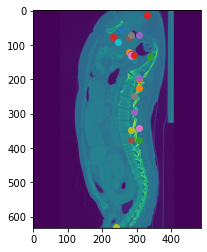

KeyboardInterrupt: 

In [2]:
from src.models.model import get_model
from src.models.predict_model import predict_test_set

# Path to the weights of latest model
WEIGHT_PATH = 'models/temp/model_05.h5'

# Load the test set
test_set = verse_dataset.test

# Create a base model and load the weights
model = get_model()
weights = model.load_weights(WEIGHT_PATH)

# Predict the test set
predict_test_set(model, test_set)